In [ ]:
'''
#determined from autocorrelation between two filter maps of an image
#the autocorrelation is found out to determine the style of an image
#trained CNN can find style of one image and apply it to the content image
#content loss : 1/2((Cc - Tc)**2).sum()
#gram matrix : vectorize the values in the layer -- flattened the 3d layer to a 2d layer * take transpose and mutiply
finally contained non localised features in the image
-- shows similarity between the feature maps
find diff between style image and content image we calculate the difference between the gram matrices
final loss is defined as a(wi((Ts - Ss)**2).sum())
add content and style loss to eventually get the total loss
multiplied with weights al1+bl2
pretrained VGG19
'''

In [1]:
%matplotlib inline
from PIL import Image # helps me load any kind of image i want to
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms , models

In [2]:
vgg = models.vgg19(pretrained = True).features

for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
def load_image(path , max_size=400 , shape = None):
    image = Image.open(path).convert('RGB')
    if(max(image.size)) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None :
        size = shape
    transform_test = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    return transform_test(image)[:3,:,:].unsqueeze(0)    

In [5]:
content = load_image('/home/nilesh/Desktop/MY FILES/ML_REVIEW/octopus.jpg')
stylized = load_image('/home/nilesh/Desktop/MY FILES/ML_REVIEW/imgstyle.jpg' , shape=content.shape[-2:])

In [6]:
def im_convert(tensor):
    
    image = tensor.clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [7]:
vgg._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace)), ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('17', ReLU(inplace)), ('18', MaxPool2d(kernel_size=2, str

In [8]:
def get_features(image, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', 
                 '5' : 'conv2_1',
                 '10' : 'conv3_1',
                 '19' : 'conv4_1',
                  '21' : 'conv5_1',
                  '28' : 'conv6_1'
                 }
    x = image
    feature_matrix = {}
    for num , layer in vgg._modules.items():
        x = layer(x)
        if num in layers:
            feature_matrix[layers[num]] = x
    return feature_matrix

In [9]:
def gram_matrix(tensor):  
    tensor = tensor.view(tensor.size()[1] , tensor.size()[2]*tensor.size()[3]) 
    return torch.mm(tensor , tensor.t())

In [10]:
content_features = get_features(content)
style_features = get_features(stylized)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True)

In [11]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  
style_weight = 1e6  

epochno   1 total loss : 106458912.0
epochno   2 total loss : 97715960.0
epochno   3 total loss : 91267136.0
epochno   4 total loss : 86286904.0
epochno   5 total loss : 82297992.0
epochno   6 total loss : 78999312.0
epochno   7 total loss : 76190960.0
epochno   8 total loss : 73738624.0
epochno   9 total loss : 71552288.0
epochno   10 total loss : 69569416.0
epochno   11 total loss : 67747296.0
epochno   12 total loss : 66056104.0
epochno   13 total loss : 64472448.0
epochno   14 total loss : 62982012.0
epochno   15 total loss : 61571892.0
epochno   16 total loss : 60232892.0
epochno   17 total loss : 58959816.0
epochno   18 total loss : 57747332.0
epochno   19 total loss : 56590644.0
epochno   20 total loss : 55485296.0
epochno   21 total loss : 54427248.0
epochno   22 total loss : 53413052.0
epochno   23 total loss : 52440264.0
epochno   24 total loss : 51505644.0
epochno   25 total loss : 50605824.0
epochno   26 total loss : 49738568.0
epochno   27 total loss : 48901328.0
epochno  

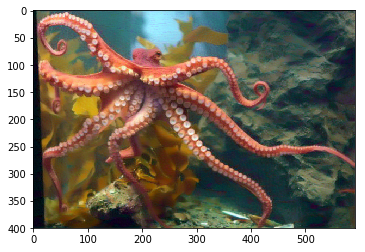

epochno   101 total loss : 16607540.0
epochno   102 total loss : 16331748.0
epochno   103 total loss : 16059265.0
epochno   104 total loss : 15790084.0
epochno   105 total loss : 15524282.0
epochno   106 total loss : 15261875.0
epochno   107 total loss : 15002922.0
epochno   108 total loss : 14747447.0
epochno   109 total loss : 14495451.0
epochno   110 total loss : 14246991.0
epochno   111 total loss : 14002090.0
epochno   112 total loss : 13760803.0
epochno   113 total loss : 13523146.0
epochno   114 total loss : 13289087.0
epochno   115 total loss : 13058671.0
epochno   116 total loss : 12831914.0
epochno   117 total loss : 12608801.0
epochno   118 total loss : 12389326.0
epochno   119 total loss : 12173507.0
epochno   120 total loss : 11961363.0
epochno   121 total loss : 11752880.0
epochno   122 total loss : 11548074.0
epochno   123 total loss : 11346966.0
epochno   124 total loss : 11149542.0
epochno   125 total loss : 10955773.0
epochno   126 total loss : 10765691.0
epochno   12

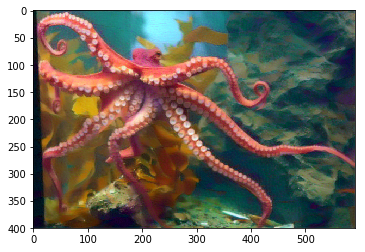

epochno   201 total loss : 4106151.0
epochno   202 total loss : 4074140.0
epochno   203 total loss : 4042712.5
epochno   204 total loss : 4011871.75
epochno   205 total loss : 3981594.75
epochno   206 total loss : 3951871.0
epochno   207 total loss : 3922688.5
epochno   208 total loss : 3894026.0
epochno   209 total loss : 3865866.25
epochno   210 total loss : 3838191.0
epochno   211 total loss : 3810989.5
epochno   212 total loss : 3784246.75
epochno   213 total loss : 3757950.25
epochno   214 total loss : 3732081.5
epochno   215 total loss : 3706640.5
epochno   216 total loss : 3681614.0
epochno   217 total loss : 3656982.0
epochno   218 total loss : 3632743.75
epochno   219 total loss : 3608894.0
epochno   220 total loss : 3585412.0
epochno   221 total loss : 3562293.25
epochno   222 total loss : 3539527.5
epochno   223 total loss : 3517105.0
epochno   224 total loss : 3495011.5
epochno   225 total loss : 3473241.25
epochno   226 total loss : 3451787.25
epochno   227 total loss : 34

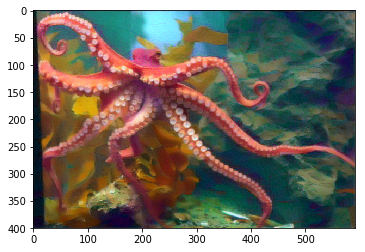

epochno   301 total loss : 2397650.0
epochno   302 total loss : 2388228.5
epochno   303 total loss : 2378885.0
epochno   304 total loss : 2369615.5
epochno   305 total loss : 2360422.0
epochno   306 total loss : 2351305.75
epochno   307 total loss : 2342261.0
epochno   308 total loss : 2333288.75
epochno   309 total loss : 2324390.75
epochno   310 total loss : 2315563.5
epochno   311 total loss : 2306806.0
epochno   312 total loss : 2298118.5
epochno   313 total loss : 2289504.0
epochno   314 total loss : 2280959.75
epochno   315 total loss : 2272483.25
epochno   316 total loss : 2264073.0
epochno   317 total loss : 2255729.0
epochno   318 total loss : 2247451.0
epochno   319 total loss : 2239235.75
epochno   320 total loss : 2231084.25
epochno   321 total loss : 2222995.5
epochno   322 total loss : 2214968.0
epochno   323 total loss : 2207000.75
epochno   324 total loss : 2199095.75
epochno   325 total loss : 2191248.75
epochno   326 total loss : 2183462.75
epochno   327 total loss : 

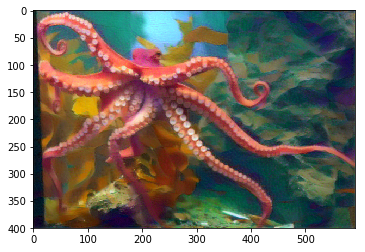

epochno   401 total loss : 1728007.375
epochno   402 total loss : 1723261.5
epochno   403 total loss : 1718543.5
epochno   404 total loss : 1713852.125
epochno   405 total loss : 1709187.5
epochno   406 total loss : 1704549.75
epochno   407 total loss : 1699939.25
epochno   408 total loss : 1695353.625
epochno   409 total loss : 1690792.625
epochno   410 total loss : 1686258.25
epochno   411 total loss : 1681749.5
epochno   412 total loss : 1677266.375
epochno   413 total loss : 1672807.125
epochno   414 total loss : 1668372.875
epochno   415 total loss : 1663963.875
epochno   416 total loss : 1659579.125
epochno   417 total loss : 1655217.5
epochno   418 total loss : 1650882.25
epochno   419 total loss : 1646569.875
epochno   420 total loss : 1642279.375
epochno   421 total loss : 1638013.75
epochno   422 total loss : 1633773.0
epochno   423 total loss : 1629556.0
epochno   424 total loss : 1625361.75
epochno   425 total loss : 1621189.75
epochno   426 total loss : 1617041.375
epochno

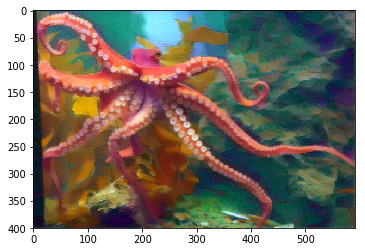

epochno   501 total loss : 1358467.375
epochno   502 total loss : 1355594.625
epochno   503 total loss : 1352733.5
epochno   504 total loss : 1349885.0
epochno   505 total loss : 1347049.25
epochno   506 total loss : 1344225.625
epochno   507 total loss : 1341414.75
epochno   508 total loss : 1338615.5
epochno   509 total loss : 1335828.625
epochno   510 total loss : 1333053.375
epochno   511 total loss : 1330290.0
epochno   512 total loss : 1327538.25
epochno   513 total loss : 1324797.875
epochno   514 total loss : 1322067.625
epochno   515 total loss : 1319349.5
epochno   516 total loss : 1316643.125
epochno   517 total loss : 1313949.0
epochno   518 total loss : 1311265.125
epochno   519 total loss : 1308592.375
epochno   520 total loss : 1305930.5
epochno   521 total loss : 1303279.875
epochno   522 total loss : 1300639.625
epochno   523 total loss : 1298010.625
epochno   524 total loss : 1295392.875
epochno   525 total loss : 1292786.375
epochno   526 total loss : 1290190.25
epoc

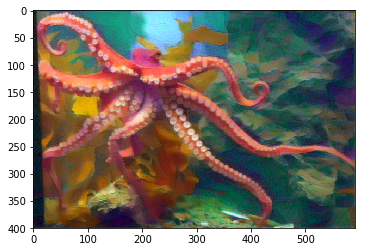

epochno   601 total loss : 1121724.125
epochno   602 total loss : 1119776.5
epochno   603 total loss : 1117835.75
epochno   604 total loss : 1115901.625
epochno   605 total loss : 1113974.375
epochno   606 total loss : 1112052.25
epochno   607 total loss : 1110137.125
epochno   608 total loss : 1108228.625
epochno   609 total loss : 1106327.5
epochno   610 total loss : 1104432.625
epochno   611 total loss : 1102544.125
epochno   612 total loss : 1100661.5
epochno   613 total loss : 1098786.125
epochno   614 total loss : 1096916.625
epochno   615 total loss : 1095052.875
epochno   616 total loss : 1093195.125
epochno   617 total loss : 1091344.75
epochno   618 total loss : 1089500.375
epochno   619 total loss : 1087662.5
epochno   620 total loss : 1085830.5
epochno   621 total loss : 1084003.75
epochno   622 total loss : 1082183.625
epochno   623 total loss : 1080370.375
epochno   624 total loss : 1078562.375
epochno   625 total loss : 1076760.875
epochno   626 total loss : 1074965.125


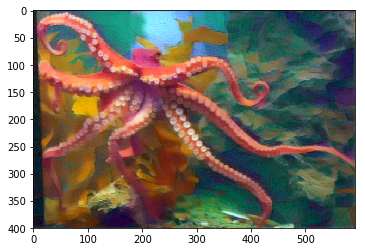

epochno   701 total loss : 955039.75
epochno   702 total loss : 953614.375
epochno   703 total loss : 952193.5
epochno   704 total loss : 950776.4375
epochno   705 total loss : 949363.5625
epochno   706 total loss : 947954.1875
epochno   707 total loss : 946548.6875
epochno   708 total loss : 945146.75
epochno   709 total loss : 943749.1875
epochno   710 total loss : 942355.0
epochno   711 total loss : 940965.125
epochno   712 total loss : 939579.1875
epochno   713 total loss : 938196.75
epochno   714 total loss : 936818.1875
epochno   715 total loss : 935443.6875
epochno   716 total loss : 934072.75
epochno   717 total loss : 932705.75
epochno   718 total loss : 931342.625
epochno   719 total loss : 929983.125
epochno   720 total loss : 928627.5
epochno   721 total loss : 927275.4375
epochno   722 total loss : 925927.5625
epochno   723 total loss : 924583.0625
epochno   724 total loss : 923242.4375
epochno   725 total loss : 921905.5
epochno   726 total loss : 920572.25
epochno   727 

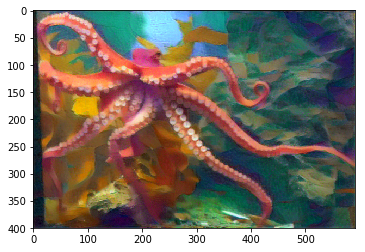

epochno   801 total loss : 829972.3125
epochno   802 total loss : 828877.5
epochno   803 total loss : 827785.0625
epochno   804 total loss : 826695.625
epochno   805 total loss : 825609.375
epochno   806 total loss : 824525.4375
epochno   807 total loss : 823444.1875
epochno   808 total loss : 822365.75
epochno   809 total loss : 821289.6875
epochno   810 total loss : 820216.1875
epochno   811 total loss : 819145.5
epochno   812 total loss : 818077.1875
epochno   813 total loss : 817011.6875
epochno   814 total loss : 815948.8125
epochno   815 total loss : 814888.9375
epochno   816 total loss : 813830.9375
epochno   817 total loss : 812775.1875
epochno   818 total loss : 811722.1875
epochno   819 total loss : 810672.125
epochno   820 total loss : 809624.3125
epochno   821 total loss : 808579.3125
epochno   822 total loss : 807536.375
epochno   823 total loss : 806495.875
epochno   824 total loss : 805458.0
epochno   825 total loss : 804422.0
epochno   826 total loss : 803389.5
epochno 

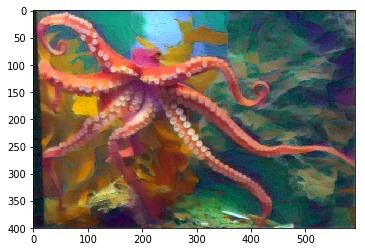

epochno   901 total loss : 732217.0
epochno   902 total loss : 731344.9375
epochno   903 total loss : 730474.8125
epochno   904 total loss : 729606.375
epochno   905 total loss : 728740.125
epochno   906 total loss : 727876.125
epochno   907 total loss : 727013.6875
epochno   908 total loss : 726153.375
epochno   909 total loss : 725294.6875
epochno   910 total loss : 724437.875
epochno   911 total loss : 723582.875
epochno   912 total loss : 722729.9375
epochno   913 total loss : 721879.0
epochno   914 total loss : 721030.0
epochno   915 total loss : 720182.75
epochno   916 total loss : 719336.875
epochno   917 total loss : 718492.6875
epochno   918 total loss : 717649.9375
epochno   919 total loss : 716809.5
epochno   920 total loss : 715970.375
epochno   921 total loss : 715133.125
epochno   922 total loss : 714297.5
epochno   923 total loss : 713463.3125
epochno   924 total loss : 712631.5
epochno   925 total loss : 711801.75
epochno   926 total loss : 710973.0625
epochno   927 tot

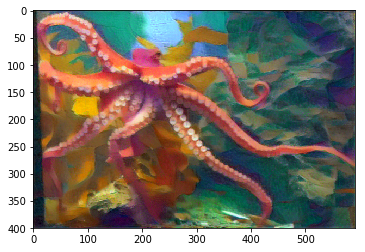

In [12]:
optimizer = optim.Adam([target] , lr = 0.005)
for epoch in range(1 , 1001):
    target_features = get_features(target)
    content_loss = torch.mean((target_features['conv5_1'] - content_features['conv5_1'])**2)
    style_loss = 0
    for layer in style_weights:
        target_gram = gram_matrix(target_features[layer])
        _, d, h, w = target_features[layer].shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    print('epochno  ' , epoch , 'total loss :' , total_loss.item())
   
    if  epoch % 100 == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

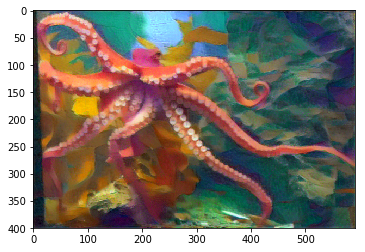

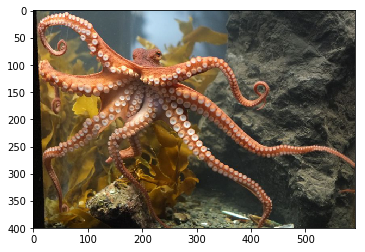

In [15]:
plt.imshow(im_convert(target))
plt.show()
plt.imshow(im_convert(content))
plt.show()